### This notebook produces Figure 2b in the paper "iCSD produces spurious results in dense electrode arrays"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from glob import glob
from tqdm import tqdm
import xarray as xr
import os, sys
import scipy
import pandas as pd
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
from scipy import stats

from scipy import interpolate

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from cinplaAnalysis.utils import *

%matplotlib ipympl

In [2]:
import matplotlib

font = {'size'   : 12}

matplotlib.rc('font', **font)

In [3]:
matplotlib.rcParams['savefig.pad_inches'] = 0

In [4]:
def gaussian(x,sig):

    curve = 1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x) / sig, 2.0) / 2)

    curve /= np.max(curve)
    
    return curve

In [34]:
totalL = np.load('0/total_overlap.npy')

In [35]:
totalL.shape

(51, 325)

In [15]:
s = np.zeros([51,9,9])
for i in range(9):
    for j in range(9):
        s[:, i, j] = totalL[:,81+i*9+j]

In [16]:
s.shape

(51, 9, 9)

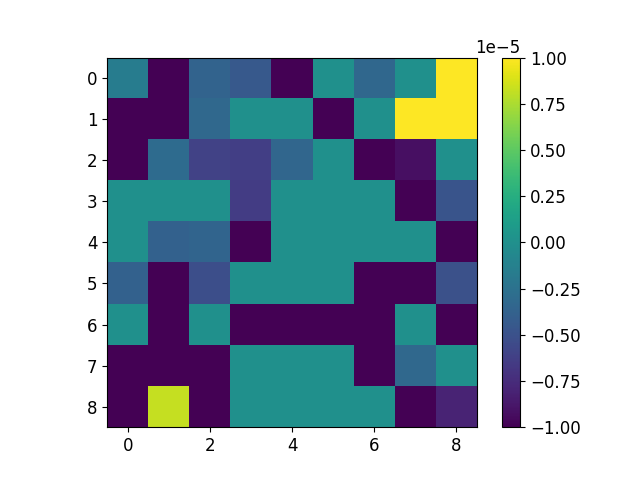

In [21]:
plt.figure()
plt.imshow(s[20],vmin=-1e-5,vmax=1e-5)
plt.colorbar()

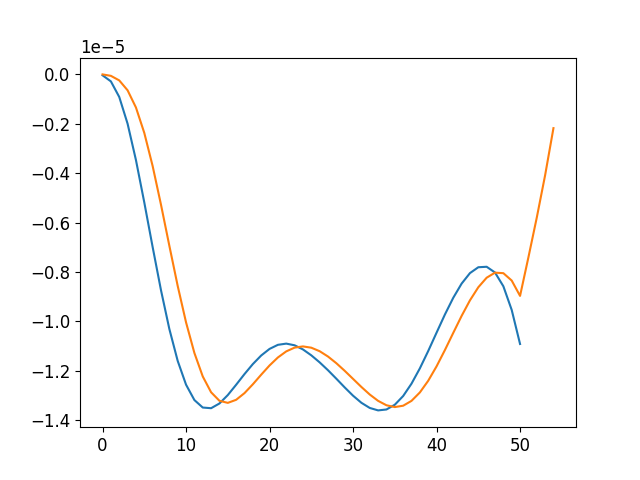

In [7]:
plt.figure()
plt.plot(totalL[:,160])
# plt.plot(totalL[:,161])

plt.plot(np.convolve(np.ones(5),totalL[:,160])/5)
# plt.plot(np.convolve(np.ones(5),totalL[:,161]))


In [22]:
'''
A line of electrodes, perpendicular to the direction of the cortical column, is placed in each of layers 6, 5, 4, and 3.
In this cell, we loop through each layer and each trial. For each electrode, the objective sphere CSD is loaded,
and the correlation matrix between electrodes is calculated (for each layer and trial separately)
'''

signals_stim = []
correlations_stim = []

for layer in range(4):
    
    signals_stim.append([])
    correlations_stim.append([])


    for trial in range(10):

        signals_stim[layer].append([])

        totalL = np.load(str(trial)+'/total_overlap.npy') # Loads objective sphere CSD
    
        for electrode in range(81):

            signal_stim = totalL[:,layer*81+electrode][20:] # Loads signal for given electrode, from stimulus onset to 50 ms after stimulus

            #signal_stim = np.convolve(np.ones(15),signal_stim)/5
        
            signals_stim[layer][trial].append(signal_stim)
        

        signals_stim[layer][trial] = np.array(signals_stim[layer][trial])    

        correlations_stim[layer].append(np.corrcoef(signals_stim[layer][trial])) # Calculates correlation matrix


    correlations_stim[layer] = np.array(correlations_stim[layer])



/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [23]:
signal_stim.shape

(31,)

In [24]:
correlations_stim = np.array(correlations_stim)

In [25]:
positionsX = 10*np.arange(-4,5) # Horizontal position of each electrode in a given layer, in um
positionsY = 10*np.arange(-4,5) # Horizontal position of each electrode in a given layer, in um

### Here, we calculate the Euclidean distance between each pair of electrodes in a given layer

distanceMat = np.zeros([81,81])

positionList = []

for i, p in enumerate(positionsX):
    for j, p1 in enumerate(positionsY):

        positionList.append( np.array([p,p1,0]) )

                                        
for i, p in enumerate(positionList):
    for j, p1 in enumerate(positionList):
        distanceMat[i,j] = np.linalg.norm(p-p1)

In [26]:
distances = np.unique(distanceMat)

In [27]:
### Here, we calculate the the mean correlation, as a function of distance between electrodes, across trials for the electrodes in each layer

mean_per_layer = []
sem_per_layer = []

for l in range(4):
    means = []
    sem = []
    means_per_distance = []
    for d in distances:
        idx = np.where(distanceMat==d)
        
        correlation = correlations_stim[l][:,idx[0],idx[1]]
        
        means_per_distance.append(correlation)
        
        means.append(np.nanmean(correlation))
        sem.append(np.nanstd(correlation))
        
    mean_per_layer.append(np.array(means))
    sem_per_layer.append(np.array(sem))

In [28]:
from scipy.optimize import curve_fit

# Here, we fit a Gaussian to the average, over all layers, of the distance-correlation function

newDistances = np.hstack((-np.flip(distances),distances))
newValues = np.hstack((np.flip(np.mean(mean_per_layer,axis=0)),np.mean(mean_per_layer,axis=0)))

sigma = curve_fit(gaussian, newDistances, newValues,p0=3)
print(sigma[0])

[7.43784719]


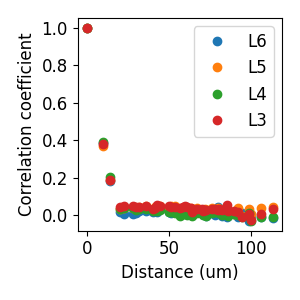

In [31]:
# This cell plots Figure 2b

plt.figure(figsize=(3,3))
for layer in range(4):
    plt.plot(distances,mean_per_layer[layer],'o')

# plt.plot(distances,gaussian(distances,sigma[0]),'k')

plt.legend(['L6','L5','L4','L3','Fit'])
plt.xlabel('Distance (um)')
plt.ylabel('Correlation coefficient')
plt.tight_layout()

plt.savefig('correlation.png',dpi=300)